# 移動平均線交易策略
Author：余慶龍  
Establish Date：2021.6.28  
Last Modified Date：2021.6.30  

## Table of Contents
1. 介紹移動平均線
2. 讀入股票資料
3. 繪出MA與股價圖
4. 策略1：簡單價線
    1. 策略介紹
    2. 策略買賣信號
    3. 策略回測
.. 額外參考資料

## 2. 讀入股票資料

In [93]:
import pandas as pd
import numpy as np

file = "../../parse_data/data/splited/1210.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

             Open   High    Low  Close  Volume
Date                                          
2019-12-27  44.15  44.15  43.70  43.90    1763
2019-12-30  44.20  44.20  43.80  44.00    1252
2019-12-31  43.90  44.10  43.60  43.65    1628
2020-01-02  43.50  43.55  42.95  43.20    3211
2020-01-03  43.20  43.20  42.20  42.45    5025
...           ...    ...    ...    ...     ...
2021-03-22  52.10  52.60  51.80  52.60    2029
2021-03-23  52.70  52.90  52.30  52.50    1734
2021-03-24  52.60  53.10  52.60  52.90    2104
2021-03-25  53.00  54.30  53.00  53.80    4763
2021-03-26  54.40  54.40  53.80  54.10    2582

[300 rows x 5 columns]


## 3. 繪出MA與股價圖

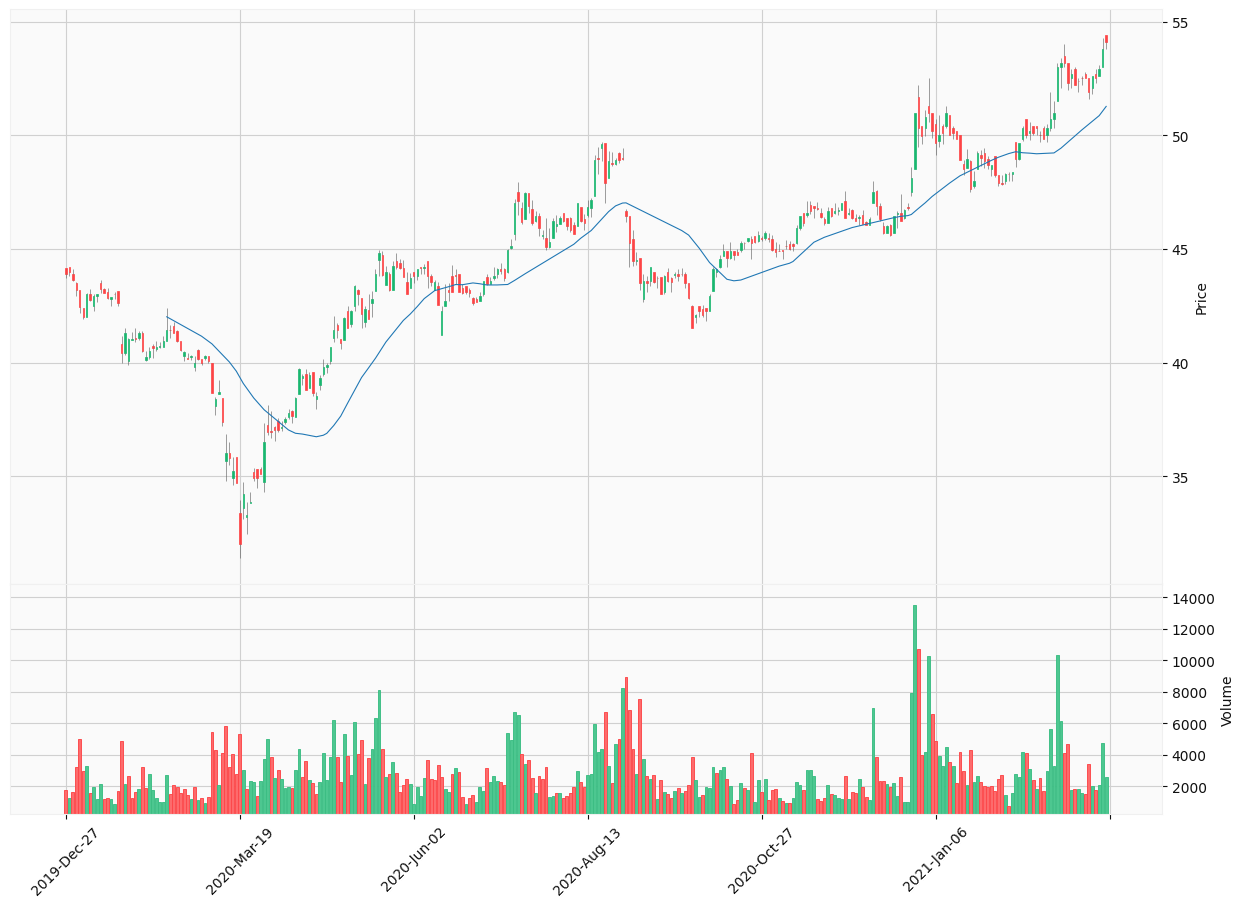

In [94]:
import mplfinance as mpf

# moving window of moving average indicator
# suhc as N = 30
MOVING_WINDOW = 30


mpf.plot( ticker, 
            type='candle',       # candlestick chart of stock price
            mav = MOVING_WINDOW, # mav is moving average window
            volume=True,         # plots trading volume as well
            figscale=2,          # make graph twice bigger
            style='yahoo')       # color scheme using 'yahoo' style

## 4. 策略1：簡單價線


### 4.1 簡單價線：策略介紹
利用股價穿越MA線為基準判斷買賣點

買入：股價往上漲破MA20 + 紅K線（美股是綠）  
賣出：股價往下跌破MA20 + 黑K線（美股是紅）  

### 4.2 簡單價線：策略買賣信號

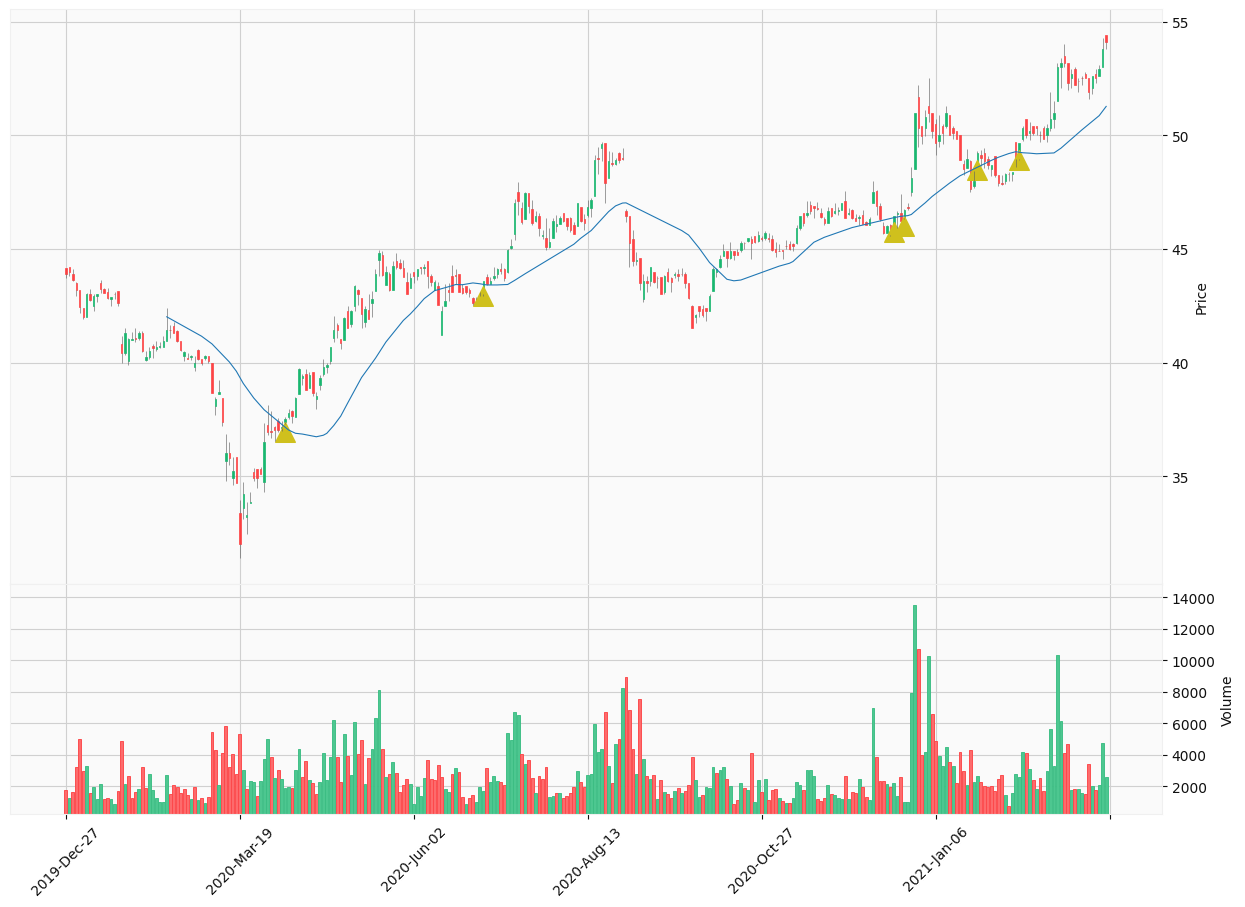

In [95]:
# make a copy from ticker
dw = ticker

# calculate moving average by pandas.DataFrame.rolling()
dw['ma'] = dw['Close'].rolling(MOVING_WINDOW).mean()

dw['buy'] = np.zeros(ticker.shape[0])
dw['sell'] = np.zeros(ticker.shape[0])



if dw.shape[0] > MOVING_WINDOW:
    for i in range(MOVING_WINDOW, dw.shape[0]):

        if(dw['Close'][i] > dw['Open'][i]):
            if (((dw.iloc[i]['Close'] > dw.iloc[i]['ma']) and
                 (dw.iloc[i-1]['Close'] < dw.iloc[i-1]['ma'])) and
                 (dw.iloc[i]['Close'] > dw.iloc[i-1]['Close'])):

                # dw['buy'][i] = 1
                #   is a simple version of this line of code
                #   however "chained indexing" should be avoided
                #   while we are setting value.
                #   checkout reference to see more.
                dw.loc[(dw.index[i], 'buy')] = 1
                
plots = []


buy, sell = [], []
for index, row in dw.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)

# 如果有賣出的記錄就放進第一個 panel(main paenl)
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
# 如果有買入的記錄就放進第一個 panel(main paenl)
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot(dw, 
            addplot = plots,
            type='candle',       # candlestick chart of stock price
            mav = MOVING_WINDOW, # mav is moving average window
            volume=True,         # plots trading volume as well
            figscale=2,          # make graph twice bigger
            style='yahoo')       # color scheme using 'yahoo' style



Other reference：
* [datetime.datetime docs](https://docs.python.org/3/library/datetime.html)
* [pandas.DataFrame.rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html#pandas-dataframe-rolling)
* why we shouldn't use chain indexing : [SettingWithCopy warning](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)
